# Transfer Learning with MobileNetV2

In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt
from keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import  RandomFlip,RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)
dir = '/content/drive/MyDrive/Transfer Learning /Alpaca classifier/dataset'

In [3]:
train_dataset = image_dataset_from_directory(dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='training',seed=42)
valid_dataset = image_dataset_from_directory(dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE,validation_split=0.2,subset='validation',seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


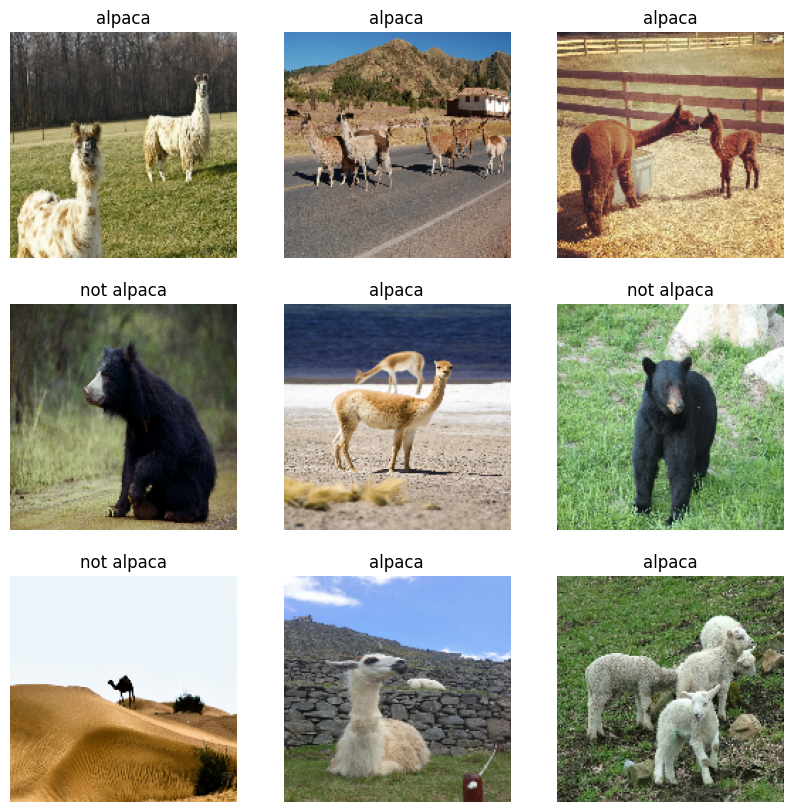

In [4]:
class_name = train_dataset.class_names
plt.figure(figsize=(10,10))
for img,labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(class_name[labels[i]])
    plt.axis('off')
plt.show()


# Preprocessed and Augment training data

In [5]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
  data_aug = tf.keras.Sequential()
  data_aug.add(RandomFlip('horizontal'))
  data_aug.add(RandomRotation(0.2))

  return data_aug

In [7]:
augmenter = data_augmenter()
assert(augmenter.layers[0].name.startswith('random_flip')), 'first layer must be randomFlip'
assert augmenter.layers[0].mode == 'horizontal','RandomFlip parameter must be horizontal'
assert(augmenter.layers[1].name.startswith('random_rotation')), 'second layer must be randomRotation'
assert augmenter.layers[1].factor == 0.2, 'Rotation factor must be 0.2'

print('\033[92mAll test passed!')

All test passed!


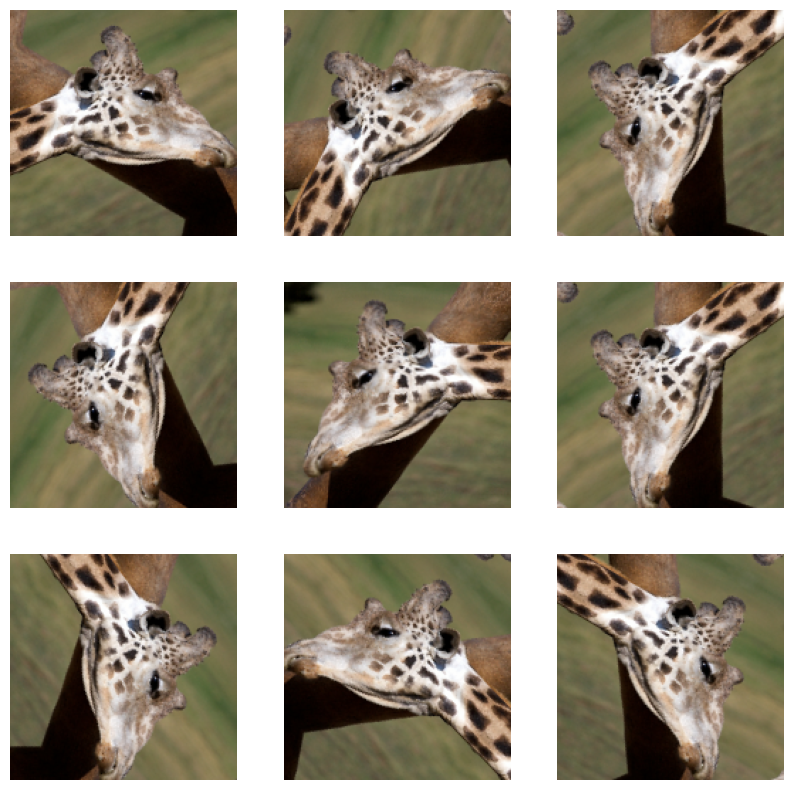

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    aug_img = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(aug_img[0]/255)
    plt.axis('off')
plt.show()

# Using MobileNetV2 Pre_model

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

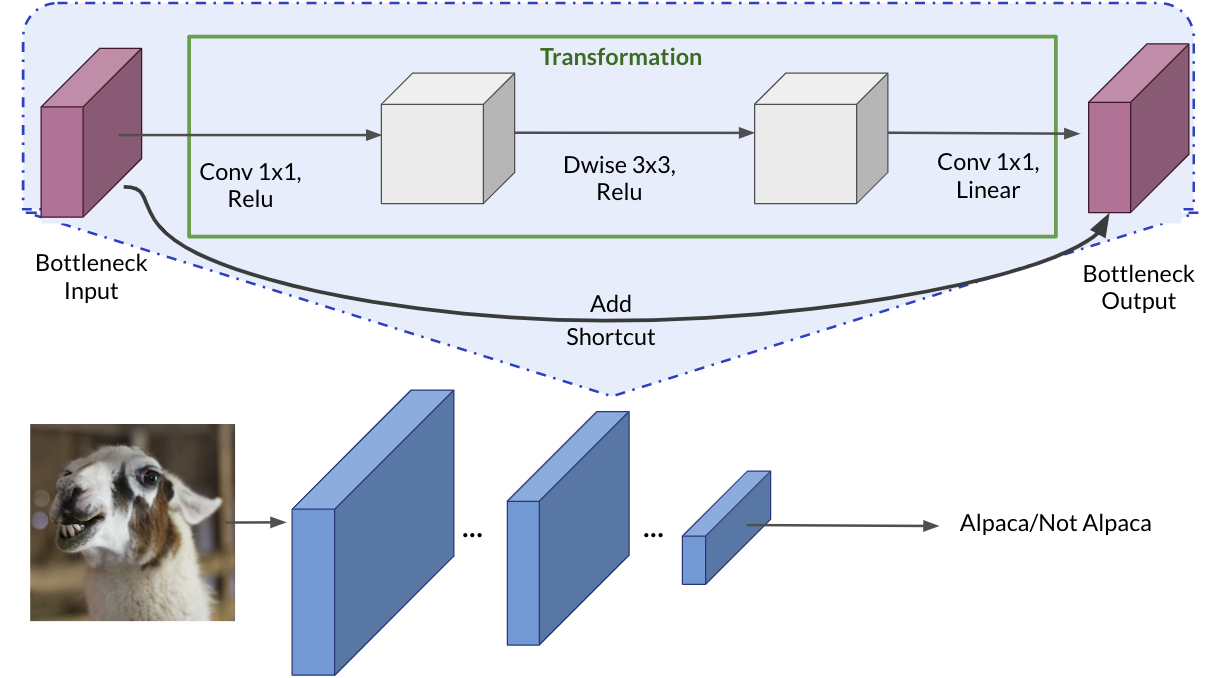

In [10]:
base_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet',input_shape=(160,160,3))

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
img_batch , label_batch = next(iter(train_dataset))
feature_batch = base_model(img_batch)
print(feature_batch.shape)

(32, 1000)


In [13]:
base_model.trainable = False
image_var = tf.Variable(img_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582163),
  ('n02708093', 'analog_clock', 0.092755675)],
 [('n04589890', 'window_screen', 0.23985945),
  ('n03887697', 'paper_towel', 0.14802651)],
 [('n04589890', 'window_screen', 0.7449457),
  ('n03598930', 'jigsaw_puzzle', 0.021948567)],
 [('n04589890', 'window_screen', 0.3354602),
  ('n03530642', 'honeycomb', 0.07628971)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.6745237),
  ('n03530642', 'honeycomb', 0.076599084)],
 [('n04589890', 'window_screen', 0.7912854),
  ('n04209239', 'shower_curtain', 0.092416056)],
 [('n04589890', 'window_screen', 0.16462995),
  ('n03598930', 'jigsaw_puzzle', 0.08749132)],
 [('n03598930', 'jigsaw_puzzle', 0.37021285),
  ('n04589890', 'window_screen', 0.09956944)],
 [('n04589890', 'window_screen', 0.616165),
  ('n03887697', 'paper_towel', 0.054876428)],
 [('n03530642', 'honeycomb', 0.25448847),
  ('n04589890', 'window_screen', 0.24874288)],
 [('

In [14]:
def alpaca_model(image_shape = IMG_SIZE,data_augmentation=data_augmenter()):
  input_shape = image_shape + (3,)
  
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,include_top=False, weights='imagenet') 

  base_model.trainable = False

  inputs = tf.keras.Input(shape=input_shape) 

  x = data_augmentation (inputs)

  x = preprocess_input (x)

  x = base_model(x,training = False)
  
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  x = tf.keras.layers.Dropout(0.2)(x)

  prediction_layer = Dense(1)

  outputs = prediction_layer(x)

  model = tf.keras.Model(inputs,outputs)

  return model    

In [15]:
Main_model = alpaca_model(IMG_SIZE,data_augmentation)

In [21]:
base_learning_rate = 0.01
Main_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['accuracy'])

In [24]:
initial_epochs = 5
history = Main_model.fit(train_dataset, validation_data=valid_dataset, epochs=initial_epochs)


Epoch 1/5
9/9 [==============================] - 25s 2s/step - loss: 0.7061 - accuracy: 0.6374 - val_loss: 0.2948 - val_accuracy: 0.8000
Epoch 2/5
9/9 [==============================] - 11s 926ms/step - loss: 0.3540 - accuracy: 0.8092 - val_loss: 0.1452 - val_accuracy: 0.9846
Epoch 3/5
9/9 [==============================] - 9s 727ms/step - loss: 0.2710 - accuracy: 0.8855 - val_loss: 0.1010 - val_accuracy: 0.9692
Epoch 4/5
9/9 [==============================] - 11s 720ms/step - loss: 0.2707 - accuracy: 0.8740 - val_loss: 0.0932 - val_accuracy: 0.9385
Epoch 5/5
9/9 [==============================] - 13s 1s/step - loss: 0.1902 - accuracy: 0.9160 - val_loss: 0.0818 - val_accuracy: 0.9692


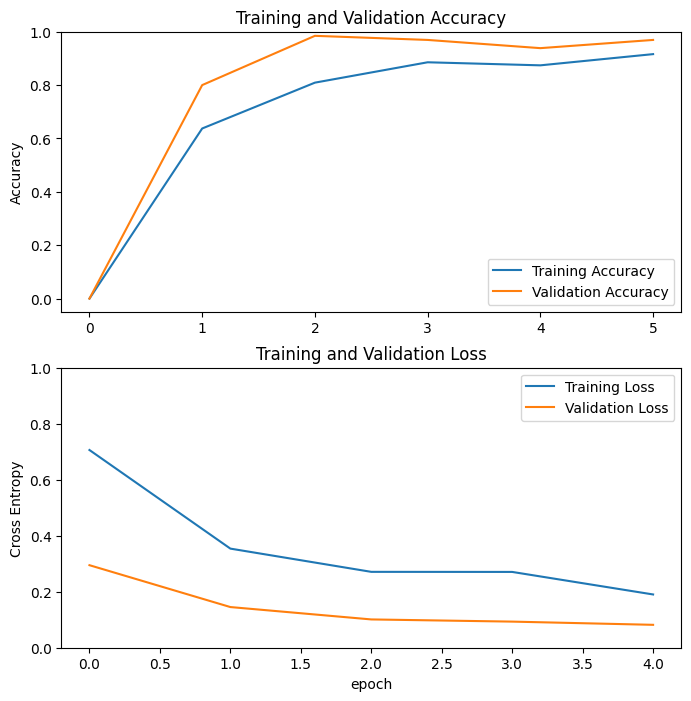

In [25]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()